### Background

Sales data for 45 Walmart stores.
Predict demand accurately.
Holiday weeks affect demand.

Dataset Info: Historical data that covers sales from 2010-02-05 to 2012-11-01. You will find the following variables:

* Store - the store number
* Date - the week of sales
* Weekly_Sales - sales for the given store
* Holiday_Flag - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week
* Temperature - Temperature on the day of sale
* Fuel_Price - Cost of fuel in the region
* CPI – Prevailing consumer price index
* Unemployment - Prevailing unemployment rate
* Holiday Events - Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13\ Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13\ Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\ Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

### 1. Data Exploration

In [2]:
#Importing the basic librarires

import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
 

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'xgboost'

In [2]:
#Importing the datasets

df_store = pd.read_csv('walmart_data/stores.csv') #store data

df_train = pd.read_csv('walmart_data/train.csv') # train set

df_features = pd.read_csv('walmart_data/features.csv') #external information

df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [3]:
#Look at data

df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
# merging datasets

df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')

df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [6]:
# removing dublicated column
df.drop(['IsHoliday_y'], axis=1,inplace=True)

# rename the column
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)

df.head() # last ready data set

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [7]:
df.shape

(421570, 16)

In [8]:
df['Store'].nunique() # number of different values
df['Dept'].nunique() # number of different values

#45 Stores and 81 Dept

81

In [9]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
store_dept_table.head()

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,...,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,...,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,...,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,...,89248.965524,66535.407203,159365.107902,67815.163007,68159.106573,147236.473706,38346.573077,39339.238951,15009.249371,623.182381
5,9774.553077,12317.953287,4101.085175,9860.806783,6699.202238,1191.057622,6124.484336,13735.709441,7919.805944,9783.395385,...,3059.520000,1457.221678,7759.205594,NaN,411.431486,19340.693986,5985.671119,667.070315,29.976087,NaN


In [10]:
#some wrong values such as there are 0 and minus values for weekly sales

df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


In [11]:
df = df.loc[df['Weekly_Sales'] > 0]
df.shape

(420212, 16)

In [12]:
#Date
df['Date'].head(5).append(df['Date'].tail(5)) # to see first and last 5 rows.

0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, dtype: object

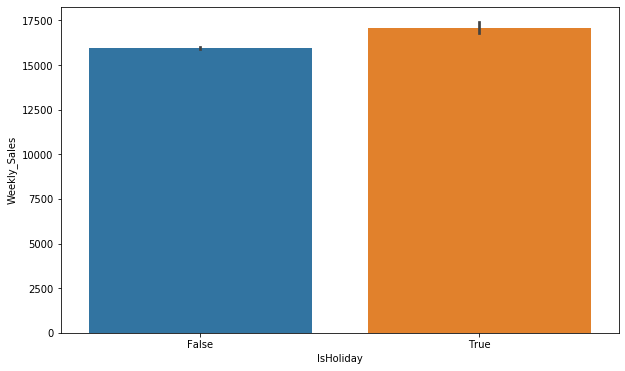

In [13]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [14]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420212 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         420212 non-null  int64  
 1   Dept          420212 non-null  int64  
 2   Date          420212 non-null  object 
 3   Weekly_Sales  420212 non-null  float64
 4   IsHoliday     420212 non-null  bool   
 5   Temperature   420212 non-null  float64
 6   Fuel_Price    420212 non-null  float64
 7   MarkDown1     150181 non-null  float64
 8   MarkDown2     110904 non-null  float64
 9   MarkDown3     136651 non-null  float64
 10  MarkDown4     134518 non-null  float64
 11  MarkDown5     150929 non-null  float64
 12  CPI           420212 non-null  float64
 13  Unemployment  420212 non-null  float64
 14  Type          420212 non-null  object 
 15  Size          420212 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 71.7+ MB


In [16]:
df = df.fillna(0) # filling null's with 0 for markdown columns

In [17]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [18]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [19]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [20]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

In [21]:
# Encoding the Data
# change holidays boolean values to 0-1 and replace type of the stores from A, B, C to 1, 2, 3.

type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df['Type'] = df['Type'].replace(type_group)

df['Super_Bowl'] = df['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1

df['Thanksgiving'] = df['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1

df['Labor_Day'] = df['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1

df['Christmas'] = df['Christmas'].astype(bool).astype(int) # changing T,F to 0-1

df['IsHoliday'] = df['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [22]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0
3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0
4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,151315,0,0,0,0


In [23]:
# Reframing the columns

df.Date=pd.to_datetime(df.Date)

df['weekday'] = df.Date.dt.weekday
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year

# df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
#                                       8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})

#df.drop(['Date'], axis=1, inplace=True)#,'month'

target = 'Weekly_Sales'
features = [i for i in df.columns if i not in [target]]
original_df = df.copy(deep=True)

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,weekday,month,year
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,...,8.106,1,151315,0,0,0,0,4,2,2010
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,...,8.106,1,151315,0,0,0,0,4,2,2010
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.0,0.0,0.0,...,8.106,1,151315,0,0,0,0,4,2,2010
3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.0,0.0,0.0,...,8.106,1,151315,0,0,0,0,4,2,2010
4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.0,0.0,0.0,...,8.106,1,151315,0,0,0,0,4,2,2010


In [24]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420212 entries, 0 to 421569
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         420212 non-null  int64         
 1   Dept          420212 non-null  int64         
 2   Date          420212 non-null  datetime64[ns]
 3   Weekly_Sales  420212 non-null  float64       
 4   IsHoliday     420212 non-null  int64         
 5   Temperature   420212 non-null  float64       
 6   Fuel_Price    420212 non-null  float64       
 7   MarkDown1     420212 non-null  float64       
 8   MarkDown2     420212 non-null  float64       
 9   MarkDown3     420212 non-null  float64       
 10  MarkDown4     420212 non-null  float64       
 11  MarkDown5     420212 non-null  float64       
 12  CPI           420212 non-null  float64       
 13  Unemployment  420212 non-null  float64       
 14  Type          420212 non-null  int64         
 15  Size          420

In [25]:
# drop holiday columns from my data and try without them.

drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df.drop(drop_col, axis=1, inplace=True) # dropping columns

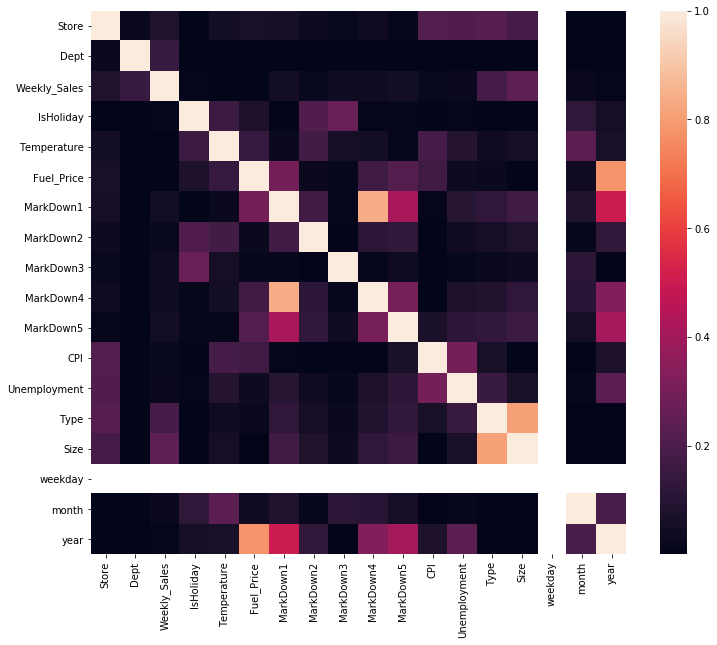

In [26]:
plt.figure(figsize = (12,10))
sns.heatmap(df.corr().abs())    # To see the correlations
plt.show()

Temperature, unemployment, CPI have no significant effect on weekly sales. Also, Markdown 4 and 5 highly correlated with Markdown 1. Drop them also. It can create multicollinearity problem.

In [27]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df.drop(drop_col, axis=1, inplace=True) # dropping columns

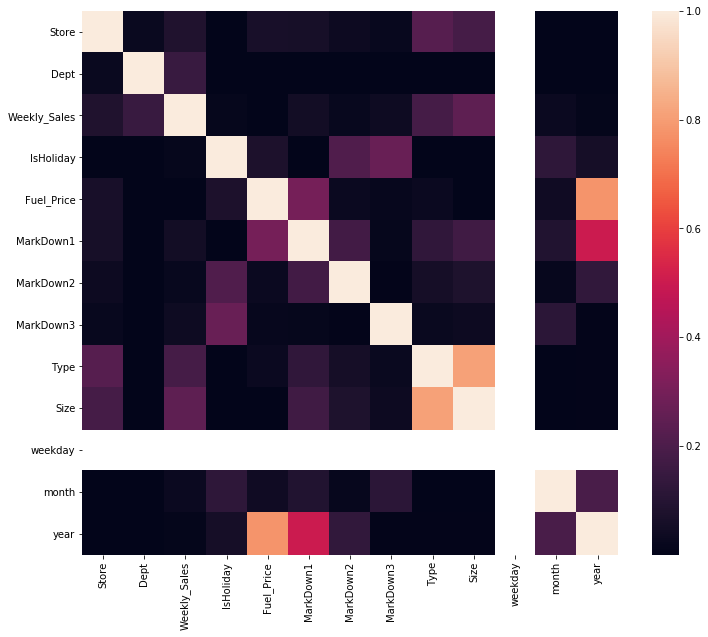

In [28]:
plt.figure(figsize = (12,10))
sns.heatmap(df.corr().abs())    # To see the correlations without dropping columns
plt.show()

Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales.

In [29]:
df = df.sort_values(by='Date', ascending=True) # sorting according to date

In [30]:
#Split data
train_data = df[:int(0.7*(len(df)))] # taking train part
test_data = df[int(0.7*(len(df))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

X = df[used_cols] # to keep train and test X values together

X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

### 2. Exploratory Data Analysis (EDA)

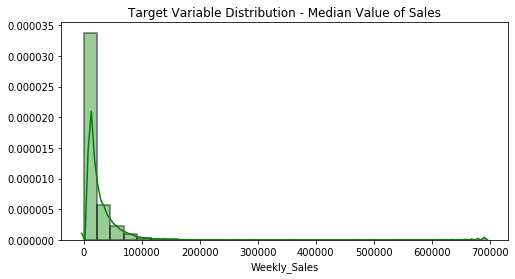

In [36]:
# distribution of the target variable
plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Sales')
plt.show()

In [32]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [33]:
# make predictions
predictions = my_model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 3296.8786006086375


In [34]:
from sklearn.model_selection import cross_val_score, KFold
scores = cross_val_score(my_model, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.90


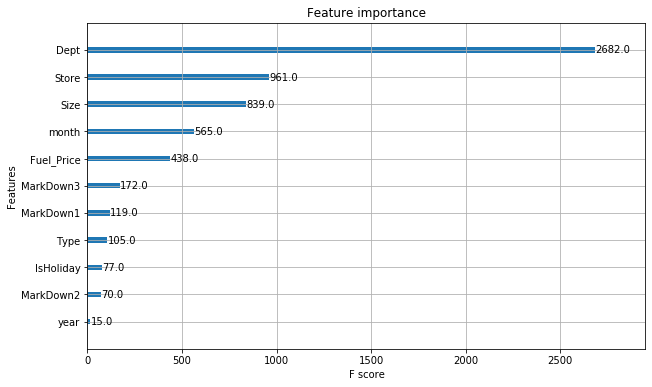

In [35]:
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(my_model)
pyplot.show()

In [38]:
library(keras)
#create a sequential model
modnn = keras_model_sequential()
  # Input layer
  layer_dense(units = 50, activation = "relu",
              input_shape =  ncol(x)) 
  #layer_dropout(rate = 0.4) %>% 
  # Hidden layer
  #layer_dense(units = 75, activation = "relu") %>%
  # Output layer: final output is one var
  layer_dropout(rate = 0.4)
  layer_dense(units = 1, activation = "sigmoid")

IndentationError: unexpected indent (<ipython-input-38-61af4fed4493>, line 5)

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

# define base model
def baseline_model():
 # create model
 model = Sequential()
 model.add(Dense(13, input_shape=(13,), kernel_initializer='normal', activation='relu'))
 model.add(Dense(1, kernel_initializer='normal'))
 # Compile model
 model.compile(loss='mean_squared_error', optimizer='adam')
 return model
# evaluate model
estimator = KerasRegressor(model=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: initialization failed